# Read Images

In [54]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

import torch.nn as nn
import torch.nn.functional as F

In [55]:
tumor = []
healthy = []

path = "data/yes/*.jpg"
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge((r, g, b))  
    tumor.append(img)

path = "data/no/*.jpg"
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge((r, g, b))  
    healthy.append(img)


In [56]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

# Visualize

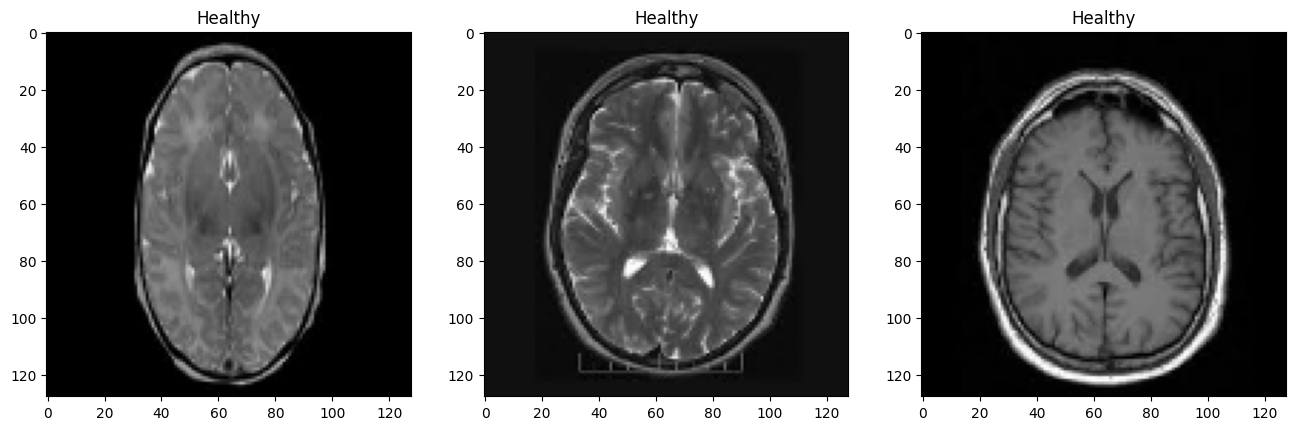

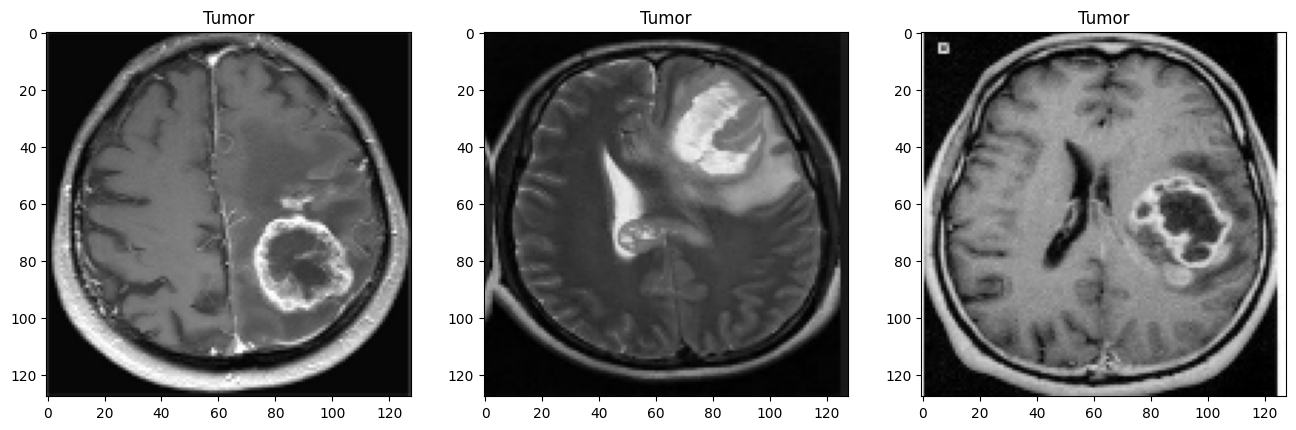

In [57]:
def plot_random(healthy, tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(healthy_imgs[i])
        plt.title("Healthy")
                
    plt.figure(figsize=(16, 9))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(tumor_imgs[i])
        plt.title("Tumor")
                
plot_random(healthy, tumor, num=3)
    

# Pytorch dataset

In [58]:

class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError("This method should be overridden by subclasses")
    def __len__(self):
        raise NotImplementedError("This method should be overridden by subclasses")
    def __add__(self, other):
        return ConcatDataset(self, other)

In [59]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []

        path = "data/yes/*.jpg"
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge((r, g, b))  
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            tumor.append(img)

        path = "data/no/*.jpg"
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge((r, g, b))  
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            healthy.append(img)

        healthy = np.array(healthy, dtype=np.float32)
        tumor = np.array(tumor, dtype=np.float32)

        tumor_labels = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_labels = np.zeros(healthy.shape[0], dtype=np.float32)
        
        self.images = np.concatenate((healthy, tumor), axis=0)
        self.labels = np.concatenate((healthy_labels, tumor_labels))

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0



In [60]:
mri = MRI()
mri.normalize()

# Dataloader

In [61]:
dataloader = DataLoader(mri, shuffle=True, batch_size=10)


# Model

In [62]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 5),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 5),
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features = 256, out_features = 120),
            nn.Tanh(),
            nn.Linear(in_features = 120, out_features = 84),
            nn.Tanh(),
            nn.Linear(in_features = 84, out_features = 1),
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
    
    

# Eval

In [63]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device("cuda:0")
model = CNN().to(device)

In [64]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        

In [65]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [66]:
def threshold(scores, threshold=0.5, minimum = 0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x


In [67]:
accuracy_score(y_true, threshold(outputs))

0.37142857142857144

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

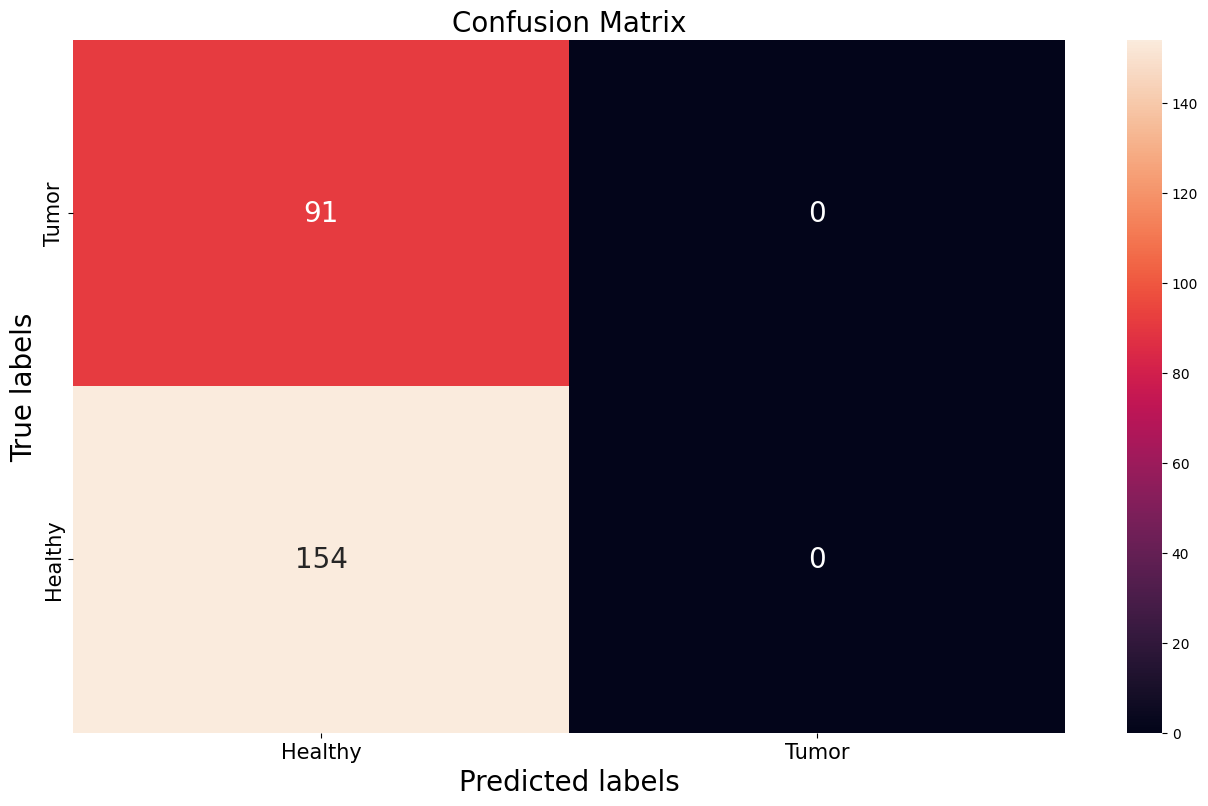

In [68]:
import seaborn as sns
plt.figure(figsize=(16, 9))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax = ax, annot_kws = {"size": 20})

ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=15)  
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'], fontsize=15)


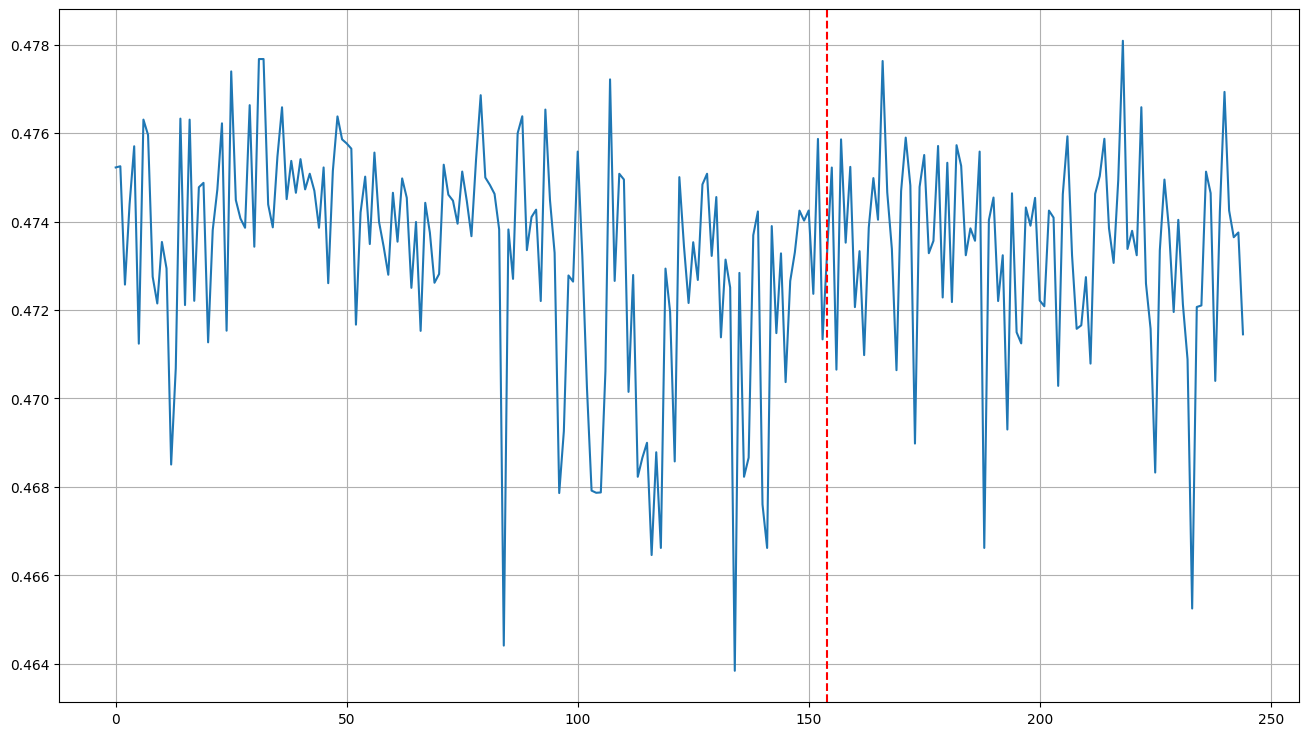

In [69]:
plt.figure(figsize=(16, 9))
plt.plot(outputs)
plt.axvline(x = len(tumor), color = 'r', linestyle='--')
plt.grid()

# Train

In [70]:
eta = 0.0001
epochs = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()



CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [71]:
for epoch in range(epochs):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if(epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {np.mean(losses):.4f}")

Epoch 10/400, Loss: 0.6237
Epoch 20/400, Loss: 0.5917
Epoch 30/400, Loss: 0.5391
Epoch 40/400, Loss: 0.4996
Epoch 50/400, Loss: 0.4900
Epoch 60/400, Loss: 0.4597
Epoch 70/400, Loss: 0.4514
Epoch 80/400, Loss: 0.4329
Epoch 90/400, Loss: 0.4294
Epoch 100/400, Loss: 0.4012
Epoch 110/400, Loss: 0.3931
Epoch 120/400, Loss: 0.3635
Epoch 130/400, Loss: 0.3342
Epoch 140/400, Loss: 0.3194
Epoch 150/400, Loss: 0.3026
Epoch 160/400, Loss: 0.2726
Epoch 170/400, Loss: 0.2434
Epoch 180/400, Loss: 0.2198
Epoch 190/400, Loss: 0.1954
Epoch 200/400, Loss: 0.1700
Epoch 210/400, Loss: 0.1490
Epoch 220/400, Loss: 0.1343
Epoch 230/400, Loss: 0.1093
Epoch 240/400, Loss: 0.0975
Epoch 250/400, Loss: 0.0813
Epoch 260/400, Loss: 0.0833
Epoch 270/400, Loss: 0.0587
Epoch 280/400, Loss: 0.0451
Epoch 290/400, Loss: 0.0401
Epoch 300/400, Loss: 0.0330
Epoch 310/400, Loss: 0.0275
Epoch 320/400, Loss: 0.0223
Epoch 330/400, Loss: 0.0186
Epoch 340/400, Loss: 0.0154
Epoch 350/400, Loss: 0.0131
Epoch 360/400, Loss: 0.0110
E

# Eval

In [72]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [73]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

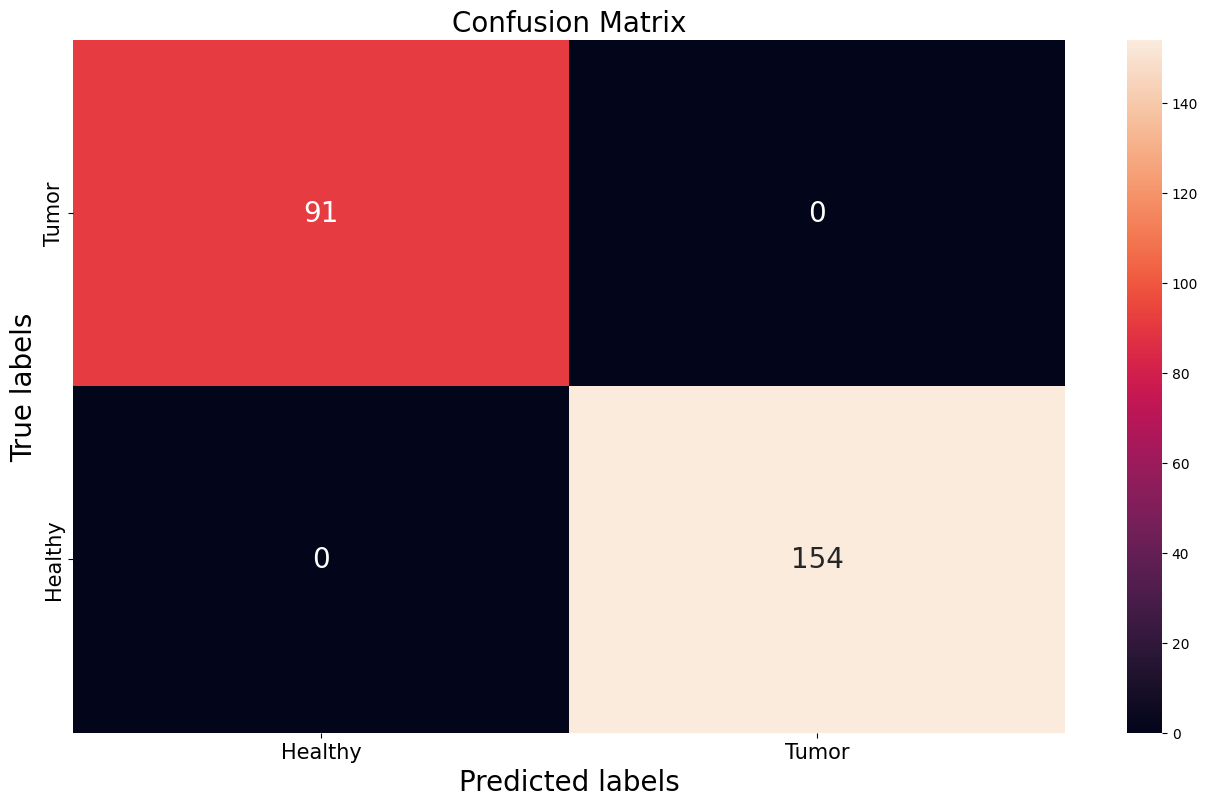

In [74]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=15)
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'], fontsize=15)


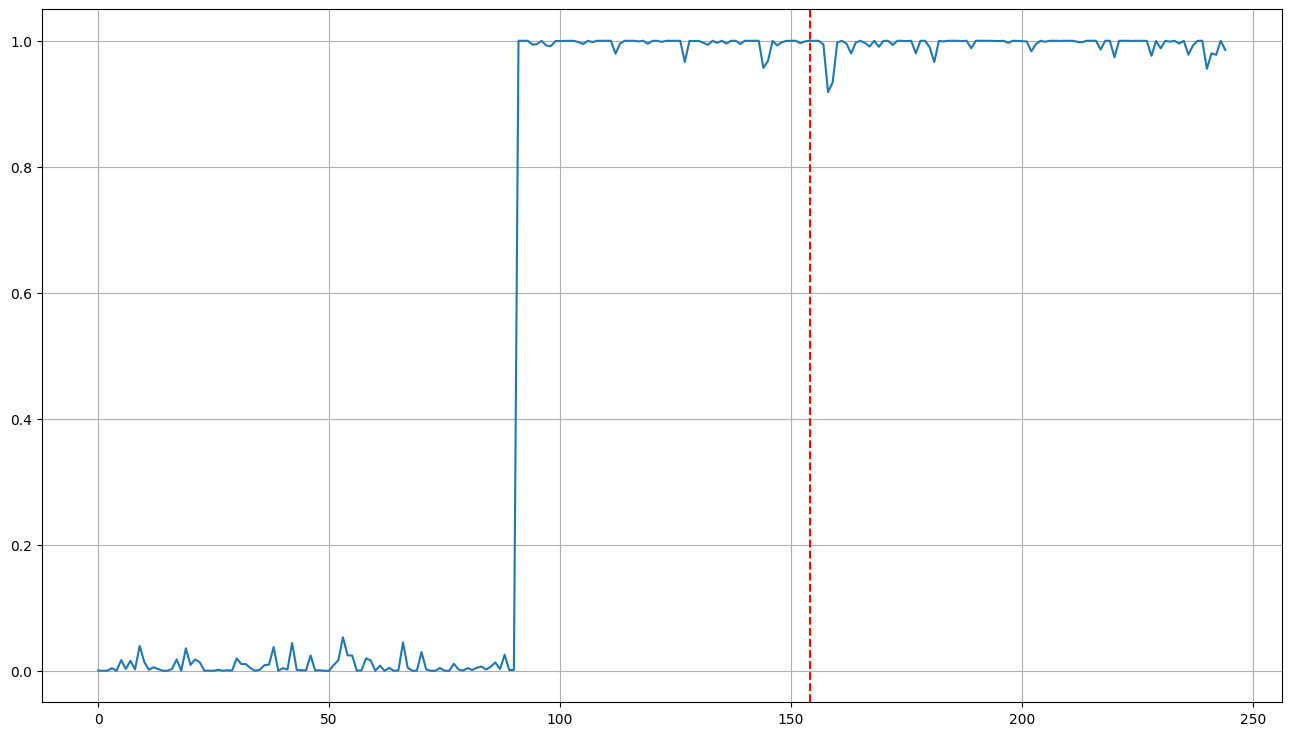

In [75]:
plt.figure(figsize=(16, 9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()


# Feature maps


In [76]:
no_of_layers = 0
conv_layers = []

In [77]:
model_children = list(model.children())
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child:
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

torch.Size([1, 3, 128, 128])

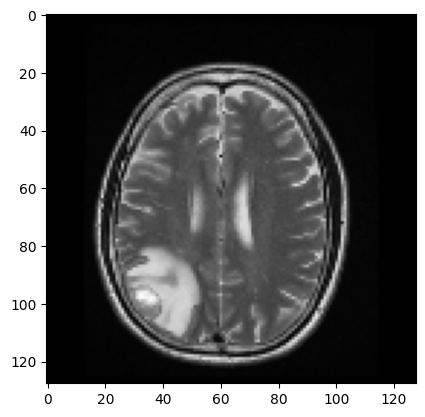

In [78]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128, 128, 3))
img  = torch.from_numpy(img).to(device).unsqueeze(0)
img.shape

In [79]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[i-1]))
outputs = results

Layer 1


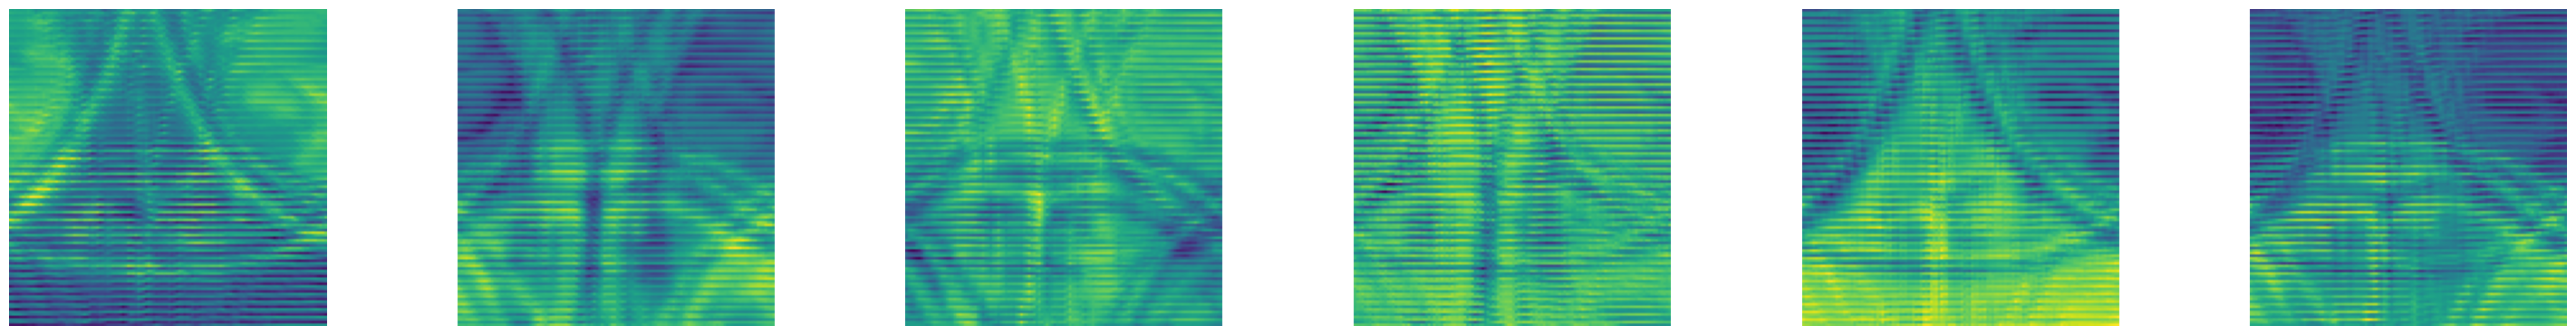

Layer 2


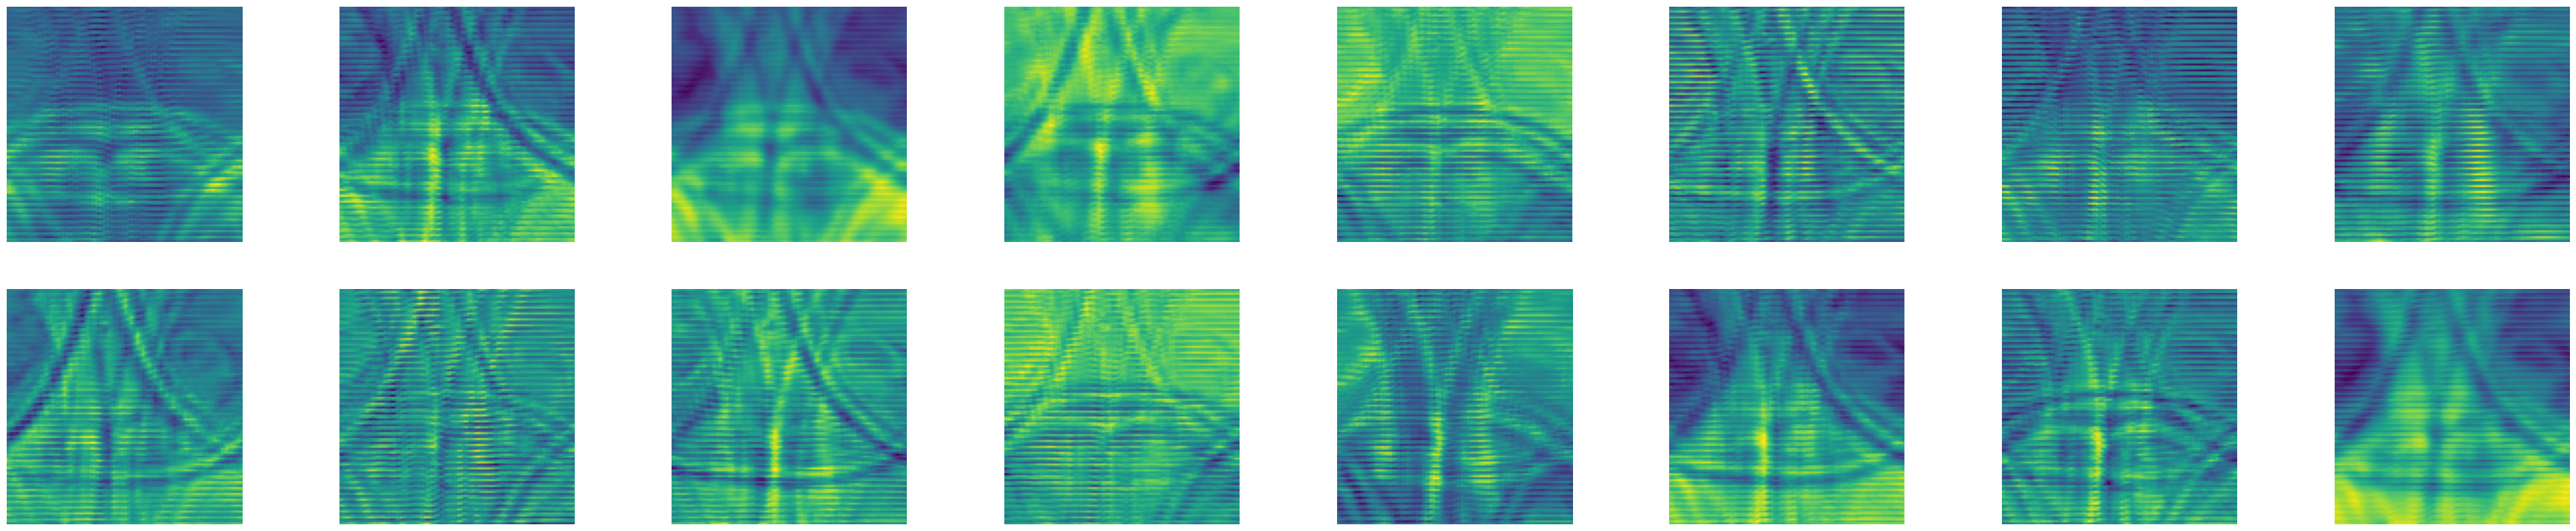

In [82]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print(f"Layer {num_layer + 1}")
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis('off')
    plt.show()